# Task 3: Semantic Textual Similarity

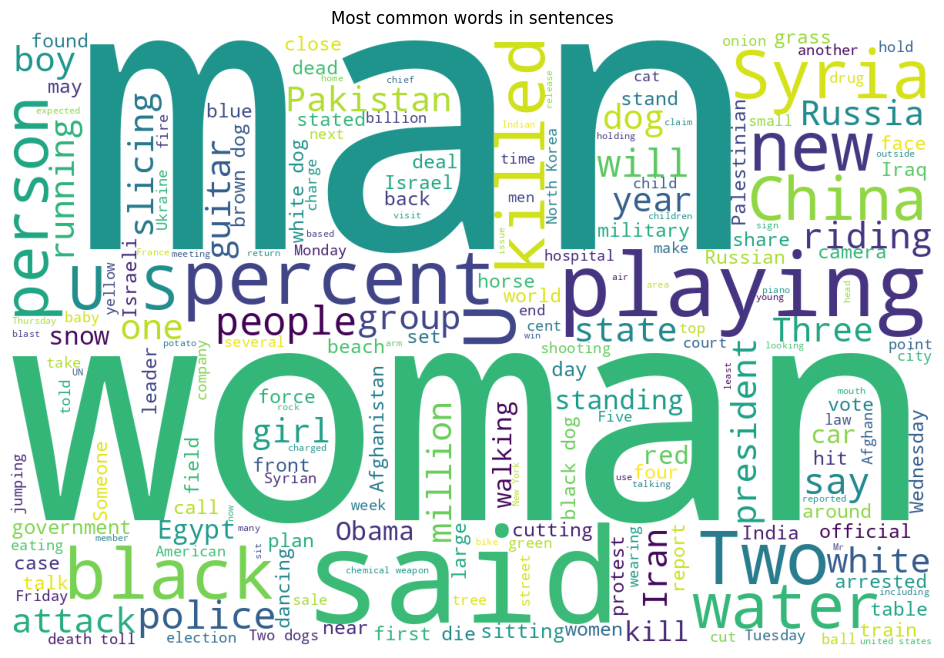

### Group members

*   Erik Galler
*   Lars Moen
*   Gjermund Bae
*   Andreas Lindkjenn Bø



# Install and import

In [ ]:
import os
from google.colab import drive
from google.colab import files
from IPython.display import Image
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLP Project')
os.getcwd()
!pip install tqdm
!pip install rank_bm25
!pip install ktrain
!pip install -U sentence-transformers
!pip install pot
!pip install GPUtil
!pip install gensim

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 65.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 39.2 MB/s et

In [ ]:
import nltk
import gensim
import ktrain
import torch
import os
import re
import pandas as pd
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import scipy.cluster.hierarchy as sch
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from rank_bm25 import BM25Okapi
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader, Dataset, RandomSampler
from ktrain import text
from absl import logging
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans

nltk.download('punkt')
nltk.download('stopwords')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
# uploaded = files.upload()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Utils

In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import gc

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    gc.collect()
    torch.cuda.empty_cache()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [ ]:
def get_results(targets, preds):
  mse = mean_squared_error(targets, preds)
  rmse = mean_squared_error(targets, preds, squared=False)

  print(f"MSE: {round(mse, 3)}")
  print(f"RMSE: {round(rmse, 3)}\n")

  return mse, rmse

In [ ]:
from sklearn.model_selection import KFold
def find_polynomial_and_write_results(maxdegree, sim_train, val_train, sim_test, scorename, train_targets, val_targets, test_targets):
    # Initialize variables to store the best degree and the minimum error
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    mse_cv = []
    best_degree = 0
    min_error = float('inf')
    for degree in range(1, maxdegree):  # Loop through degrees 1 to 5. You can adjust this range as needed.
        # Create a PolynomialFeatures object
        poly = PolynomialFeatures(degree)
        mse_kfolds = []
        # Create a pipeline of polynomial transformation and linear regression
        poly_reg = make_pipeline(poly, LinearRegression())

        for train_index, valid_index in kf.split(sim_train):
            train_sim, valid_sim = sim_train[train_index], sim_train[valid_index]
            train_targ, valid_targ = train_targets[train_index], train_targets[valid_index]

            poly_reg.fit(train_sim, train_targ)
            poly_predictions_valid = poly_reg.predict(valid_sim)
            mse = mean_squared_error(valid_targ, poly_predictions_valid)
            mse_kfolds.append(mse)
        
        mse_avg = np.mean(mse_kfolds)
        mse_cv.append(mse_avg)

        print(f"Degree: {degree}, MSE: {mse}")

        # Update the best degree and minimum error if the current model performs better
        if mse < min_error:
            min_error = mse
            best_degree = degree

    print(f"Best degree: {best_degree}, MSE: {min_error}")

    poly = PolynomialFeatures(best_degree)
    reg = make_pipeline(poly, LinearRegression())

    reg.fit(similarity_train, train_targets)

    predictions_train = reg.predict(similarity_train)
    predictions_test = reg.predict(similarity_test)
    predictions_val = reg.predict(similarity_valid)
    train_results[scorename] = predictions_train
    test_results[scorename] = predictions_test
    val_results[scorename] = predictions_val
    # Compute the mean squared error
    print('Best mse: ', mean_squared_error(val_targets, predictions_val))
    return reg

# Data Cleaning


Let us start with loading the data. There is alot of unformatted dirty data, therefore we have reformatted the different csv files to reduse the number of bad lines that we have to throw away. In some cases rows had to ble cleaned/deleted manually like in the case bellow:

![picture](https://drive.google.com/file/d/1FMUQGjeHGyI8AswHhvEs21jeNib9wiBn/view?usp=share_link)

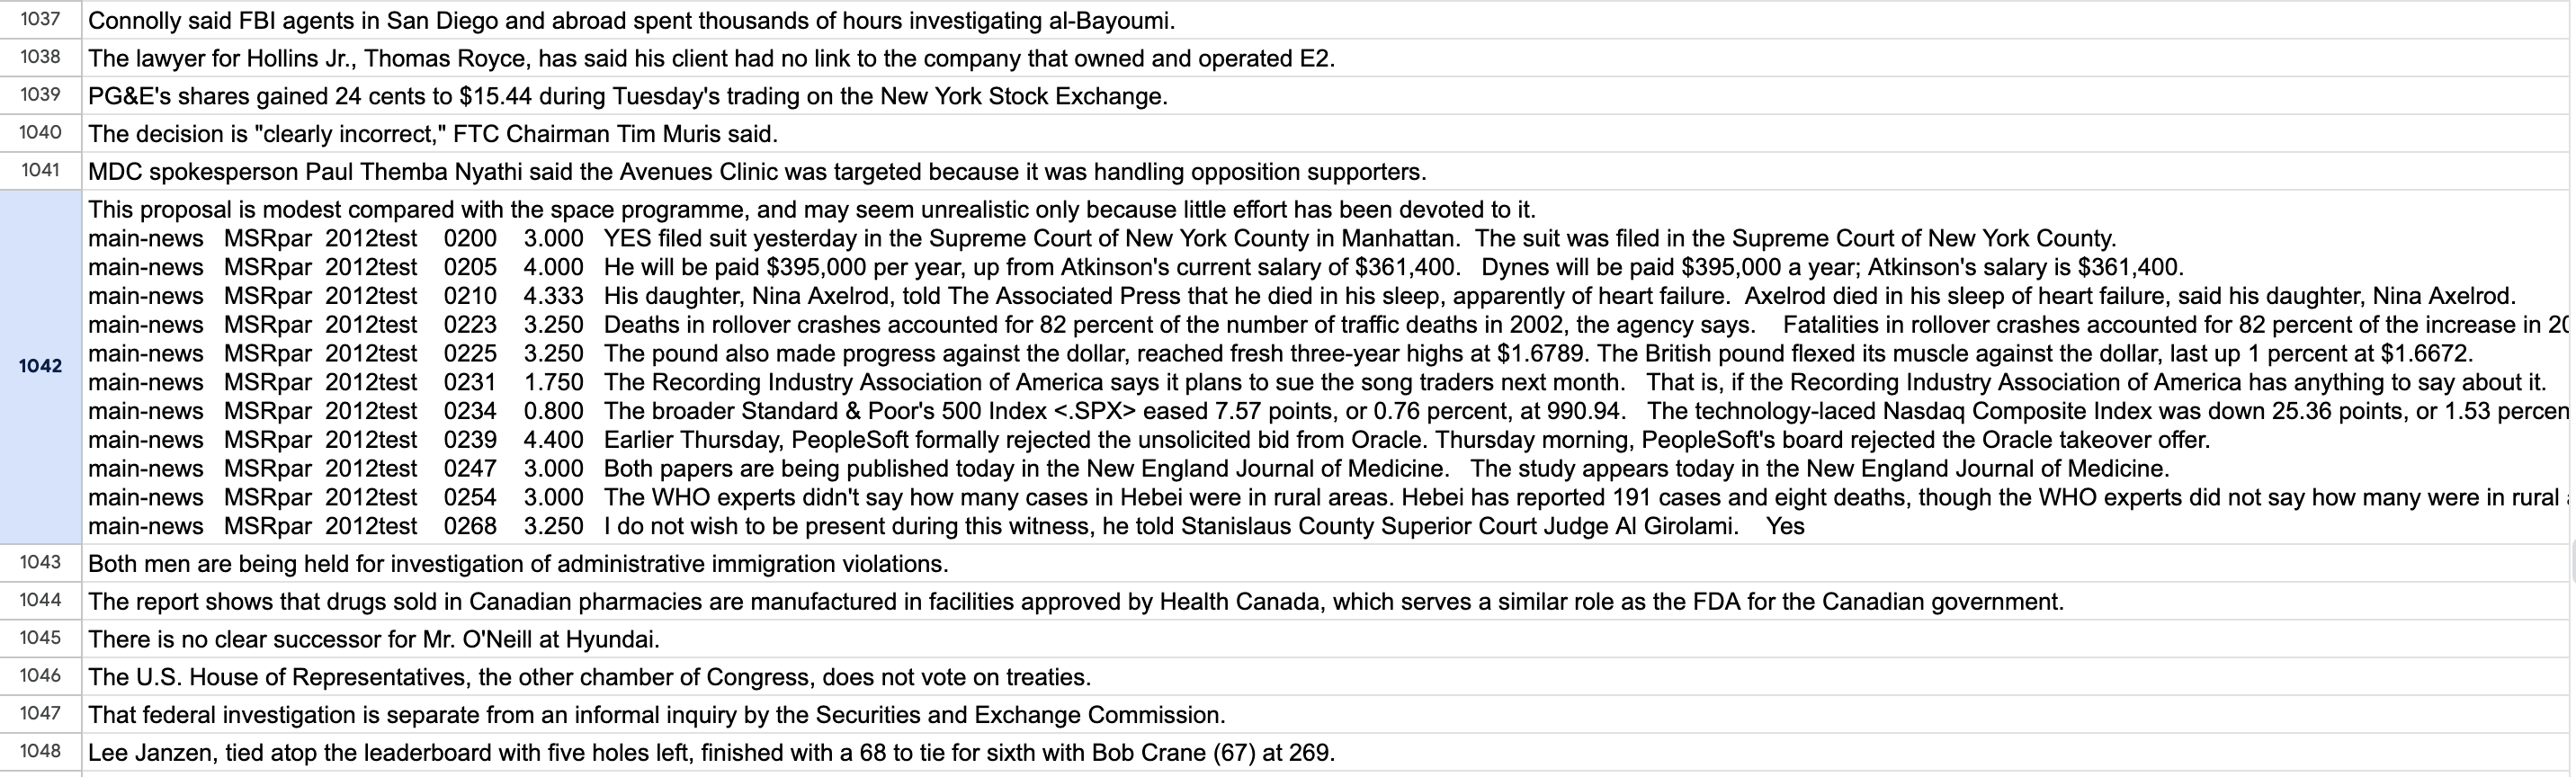

In [ ]:
Image('dirty_data.png')

In other cases we could simply remove large unwanted columns of data:

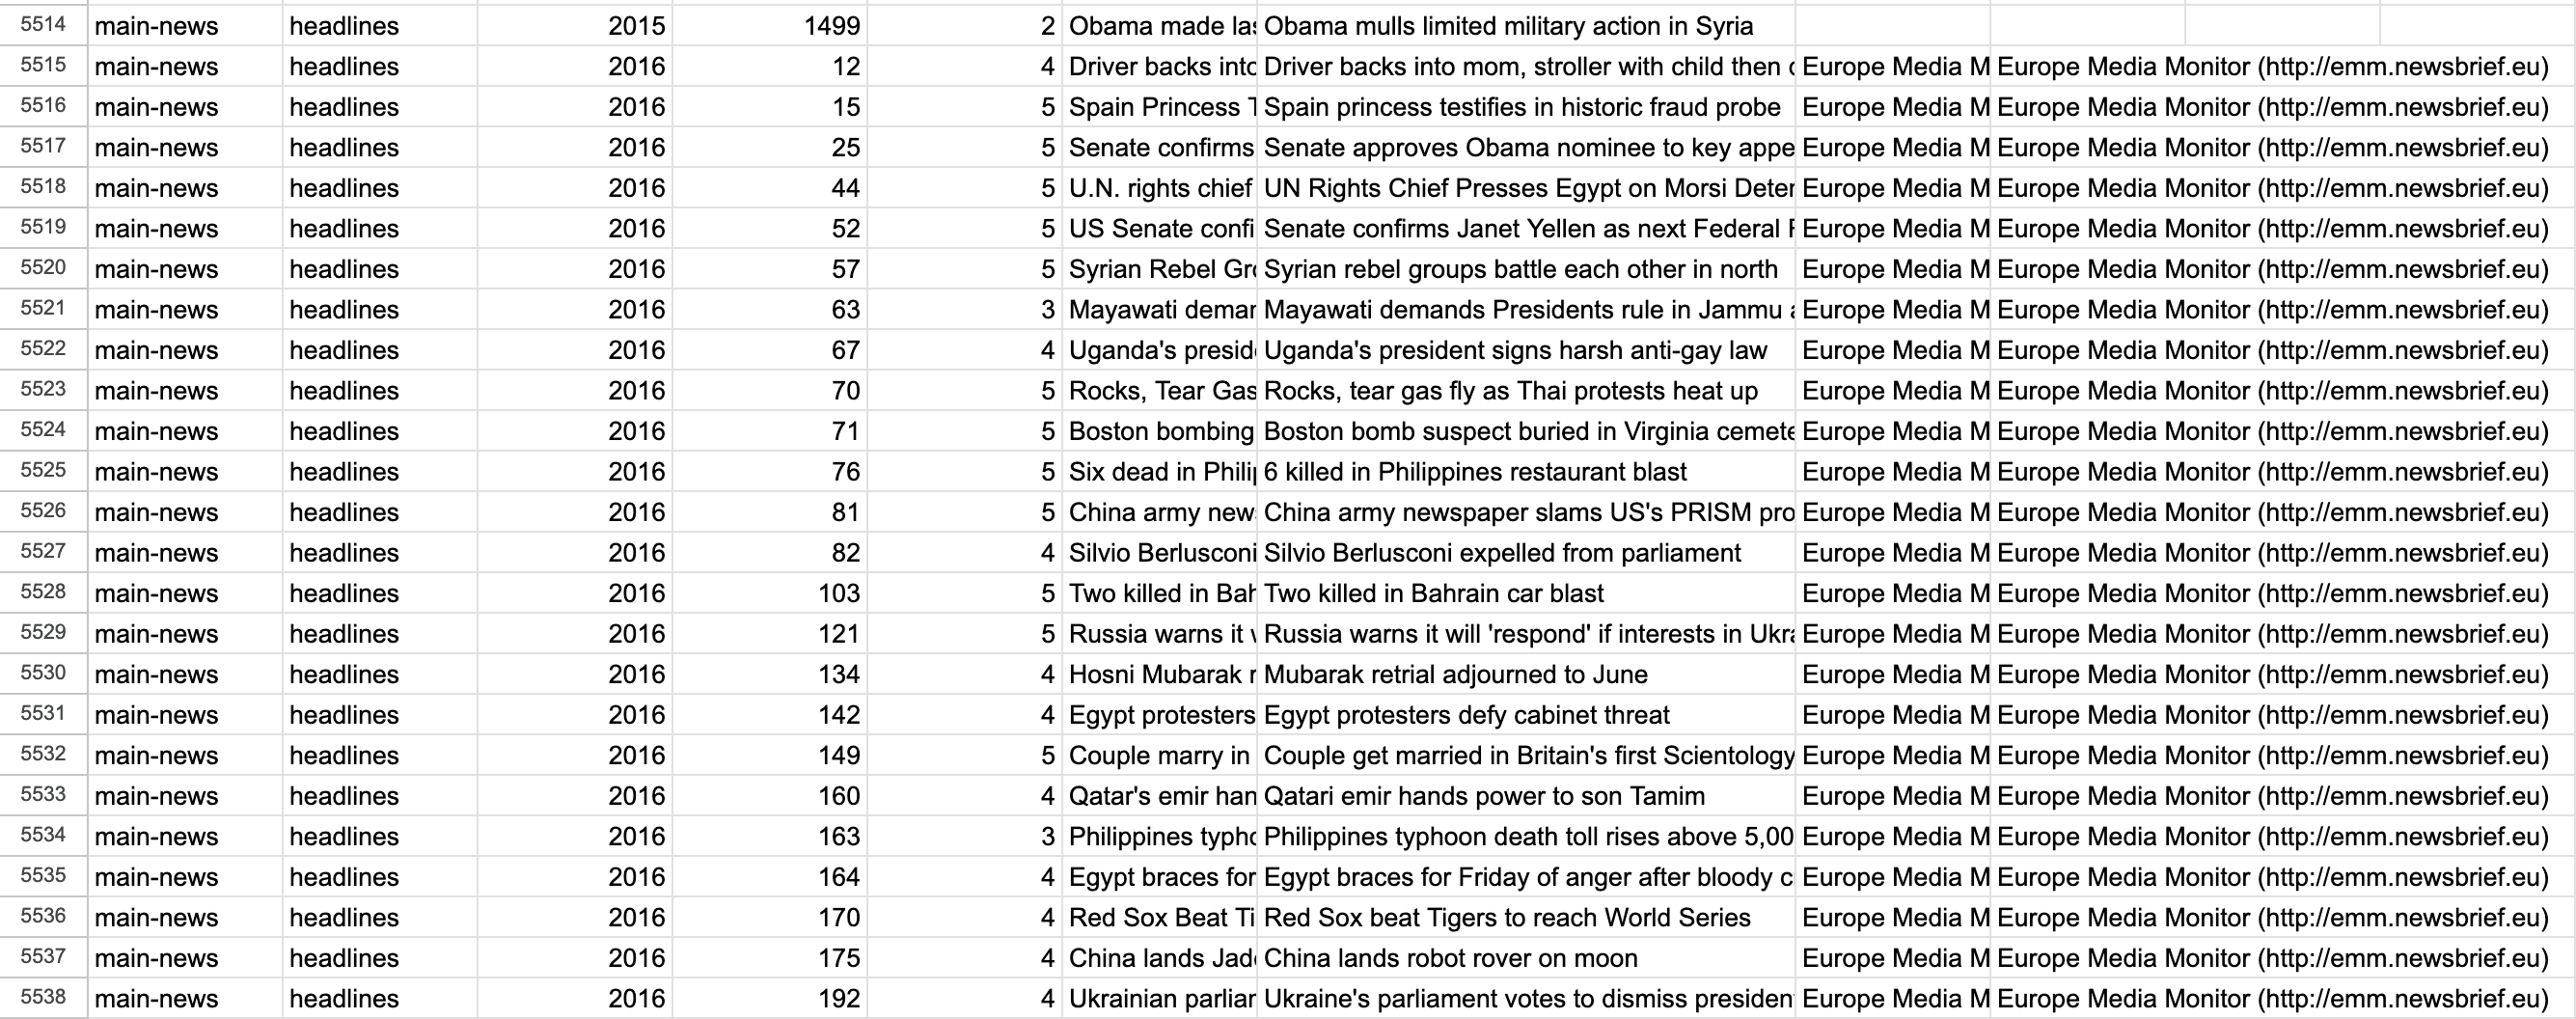

In [ ]:
Image('dirty_col.png')

In [ ]:
bad_lines_left = []
def bad_lines(row):
  print(len(row), row)
  bad_lines_left.append(row)

original_bad_lines = []
def all_bad_lines(row):
  original_bad_lines.append(row)

columns = ['genre', 'file', 'years', 'id', 'score', 'sentence1', 'sentence2']

train = pd.read_csv('data/sts-train-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_train = pd.read_csv('data/original/sts-train.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'train rows: {len(train)}')
print(f'difference in number of lines: {len(train)-len(dirty_train)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(train[train.isnull().any(axis=1)]), '\n')
train = train.dropna()
bad_lines_left, original_bad_lines = [], []

dev = pd.read_csv('data/sts-dev-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_dev = pd.read_csv('data/original/sts-dev.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'dev rows: {len(dev)}')
print(f'difference in number of lines: {len(dev)-len(dirty_dev)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(dev[dev.isnull().any(axis=1)]), '\n')
dev = dev.dropna()
bad_lines_left, original_bad_lines = [], []

test = pd.read_csv('data/sts-test-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_test = pd.read_csv('data/original/sts-test.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'test rows: {len(test)}')
print(f'difference in number of lines: {len(test)-len(dirty_test)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'test with nan:', len(test[test.isnull().any(axis=1)]), '\n')
test = test.dropna()
bad_lines_left, original_bad_lines = [], []

train.head(50)

train rows: 5749
difference in number of lines: 1571
bad lines left: 0
lines with nan: 0 

dev rows: 1500
difference in number of lines: 537
bad lines left: 0
lines with nan: 0 

test rows: 1379
difference in number of lines: 347
bad lines left: 0
test with nan: 0 



,genre,file,years,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1.0,5.000,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4.0,3.800,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5.0,3.800,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6.0,2.600,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9.0,4.250,A man is playing the cello.,A man seated is playing the cello.
...,...,...,...,...,...,...,...
45,main-captions,MSRvid,2012test,68.0,1.000,A man is playing the piano.,A woman is playing the violin.
46,main-captions,MSRvid,2012test,69.0,1.000,A woman is playing the flute.,A man is playing the guitar.
47,main-captions,MSRvid,2012test,70.0,2.375,A man is cutting up a potato.,A man is cutting up carrots.
48,main-captions,MSRvid,2012test,71.0,3.800,A kid is playing guitar.,A boy is playing a guitar.


In [ ]:
df_train = train[['sentence1', 'sentence2', 'score']].copy()
df_valid = dev[['sentence1', 'sentence2', 'score']].copy()
df_test = test[['sentence1', 'sentence2', 'score']].copy()

df_train['score'] = df_train['score'].astype(float)
df_valid['score'] = df_valid['score'].astype(float)
df_test['score'] = df_test['score'].astype(float)

train_results = train.copy()
valid_results = dev.copy()
test_results = test.copy()

train_targets = df_train['score'].values
valid_targets = df_valid['score'].values
test_targets = df_test['score'].values

In [ ]:
# Extract values of sentence1 and sentence2 into separate 1D lists
train_sentence1 = df_train['sentence1'].tolist()
train_sentence2 = df_train['sentence2'].tolist()
train_sentences = train_sentence1 + train_sentence2

valid_sentence1 = df_valid['sentence1'].tolist()
valid_sentence2 = df_valid['sentence2'].tolist()
valid_sentences = valid_sentence1 + valid_sentence2

test_sentence1 = df_test['sentence1'].tolist()
test_sentence2 = df_test['sentence2'].tolist()
test_sentences = test_sentence1 + test_sentence2

## Additional dataset

In [ ]:
files = ["sem_eval_2014_train.csv", "sem_eval_2014_test.csv", "sem_eval_2014_val.csv"]
sem_eval_2014_dataset_df = pd.DataFrame()
for file in files:
  df = pd.read_csv(file, header = 0, sep=",", names=['NA1','NA2','sentence1', 'sentence2', 'score', 'NA3'])
  sem_eval_2014_dataset_df = sem_eval_2014_dataset_df.append(df)
sem_eval_2014_dataset_df.head(5)

In [ ]:
# Convert the score to a float
sem_eval_2014_dataset_df['score'] = sem_eval_2014_dataset_df['score'].astype(float)

# Slice the b''. (It is not a b-string)
sem_eval_2014_dataset_df['sentence1'] = sem_eval_2014_dataset_df['sentence1'].str.slice(2,-1)
sem_eval_2014_dataset_df['sentence2'] = sem_eval_2014_dataset_df['sentence2'].str.slice(2,-1)
sem_eval_2014_dataset_df = sem_eval_2014_dataset_df.reset_index()[['sentence1', 'sentence2', 'score']].dropna()
sem_eval_2014_dataset_df

In [ ]:
train_sem_eval, valid_sem_eval = train_test_split(sem_eval_2014_dataset_df, test_size=df_valid.shape[0]/df_train.shape[0])

Keeping the ratio of test to validation by specifing the portion (test_size in train_test_split()).

In [ ]:
df_train = pd.concat([df_train, train_sem_eval])
df_valid = pd.concat([df_valid, valid_sem_eval])

In [ ]:
df_train[df_train.duplicated()].shape[0], df_valid[df_valid.duplicated()].shape[0] # Amount of duplicates in the datasets

(45, 2)

We will remove rows where all three columns have the exact same values, keeping only the first occurrence of each unique combination of values.

In [ ]:
df_train = df_train.drop_duplicates(keep='first')
df_valid = df_valid.drop_duplicates(keep='first')

# EDA

In [ ]:
df_EDA = train.copy()

In [ ]:
df_EDA['years'] = df_EDA['years'].replace(['2012test', '2012train'], '2012')
df_EDA['genre'] = df_EDA['genre'].replace({'main-captions': 'captions',  'main-news': 'news', 'main-forum': 'forum'})

In [ ]:
genres = df_EDA['genre'].unique()
score_bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]

Let's take a look at how the scores are distributed on the datasets. From the plot below, we can see that the train, development and test datasets have quite similar distributions. The scores are more dense around whole numbers.

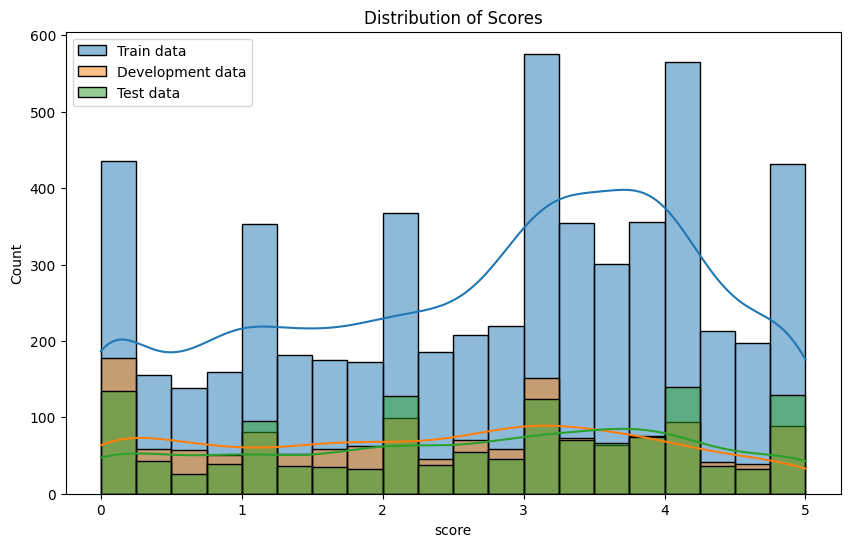

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_EDA['score'], label='Train data', kde=True, bins=20)

sns.histplot(df_dev['score'], label='Development data', kde=True, bins=20)
sns.histplot(df_test['score'], label='Test data', kde=True, bins=20)
plt.legend()
plt.title('Distribution of Scores')
plt.show()

Now let's take a look on the years that the data is fetched. From the plot below, we can see that the majority of the data is from 2012 and 2014

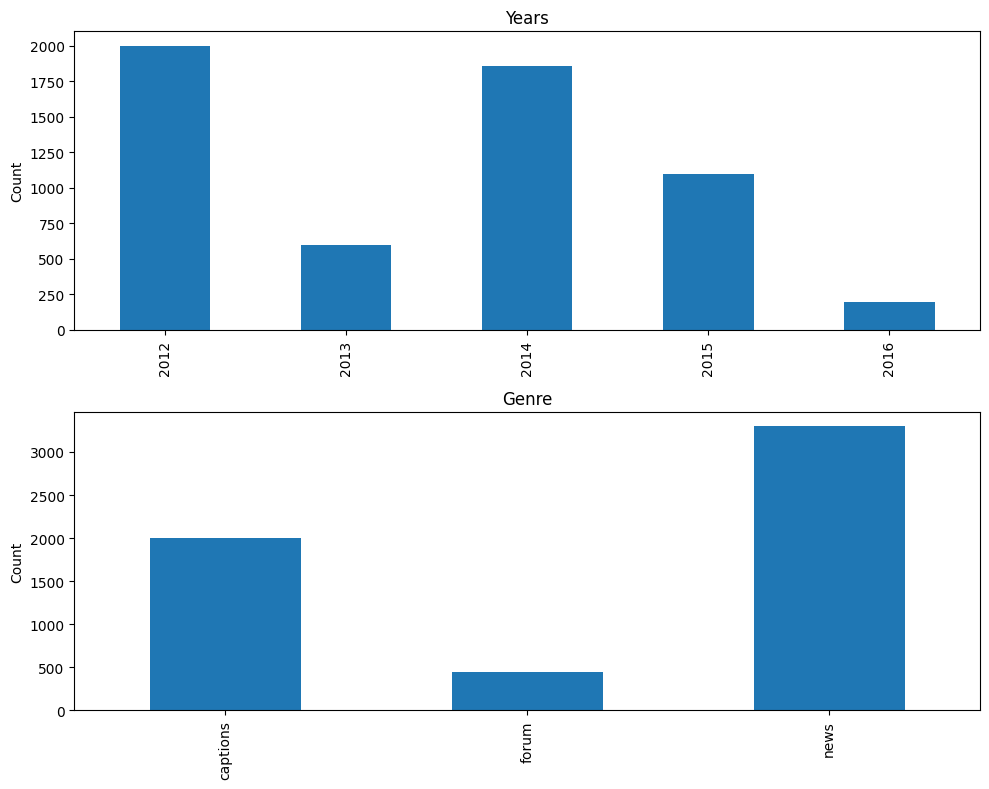

In [ ]:
plt.figure(figsize=(10,8))  # Create a new figure

plt.subplot(211)  # Add a subplot in the first position
df_EDA['years'].value_counts().sort_index().plot(kind='bar')
plt.title('Years')
plt.ylabel('Count')

plt.subplot(212)  # Add a subplot in the second position
df_EDA['genre'].value_counts().sort_index().plot(kind='bar')
plt.title('Genre')
plt.ylabel('Count')

plt.tight_layout()  # This will ensure that the plots do not overlap
plt.show()



Now, let's take a look at how the length of the sentences are distributed. 
From the plot below, we can see that the sentences have a quite similar distribution and are most dense around 5-10 words

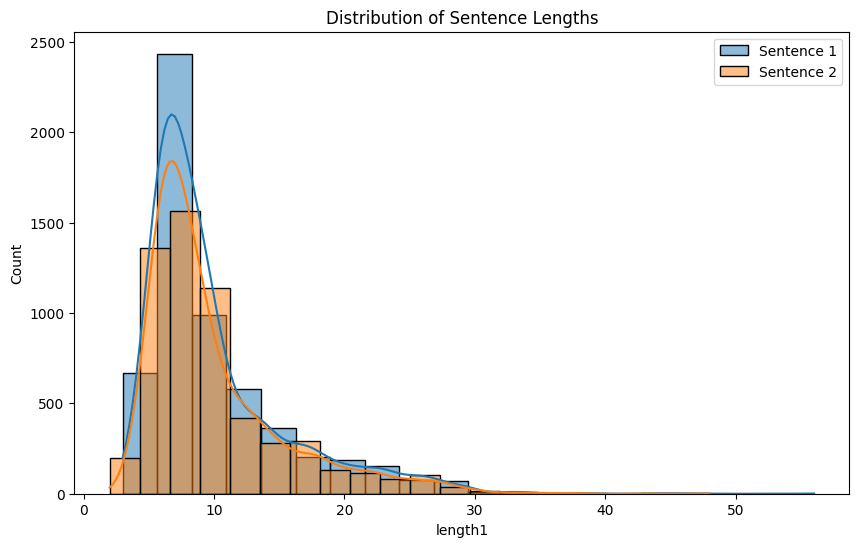

In [ ]:
df_EDA['length1'] = df_EDA['sentence1'].apply(lambda x: len(x.split()))
df_EDA['length2'] = df_EDA['sentence2'].apply(lambda x: len(x.split()))
df_EDA['avg_length'] = (df_EDA['length1'] + df_EDA['length2']) / 2
plt.figure(figsize=(10,6))
sns.histplot(df_EDA['length1'], label='Sentence 1', kde=True, bins=20)
sns.histplot(df_EDA['length2'], label='Sentence 2', kde=True, bins=20)
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()



Below is a plot visualizing how the scores are distributed over different genres. The different distributions are quite similar. The news genre has a slightly higher median than the captions and forum

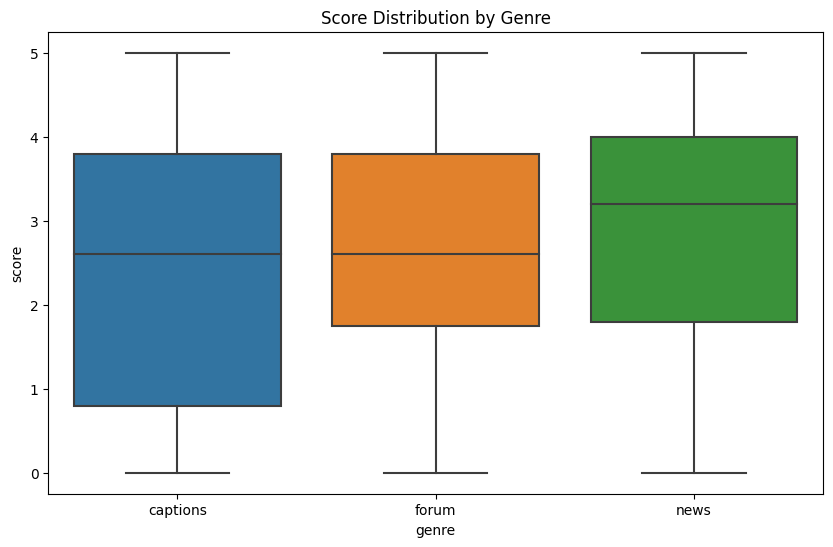

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='genre', y='score', data=df_EDA)
plt.title('Score Distribution by Genre')
plt.show()



We can do the same with year. 2016 has a lower median than the rest. Keep in mind that 2016 also had the least amount of data.

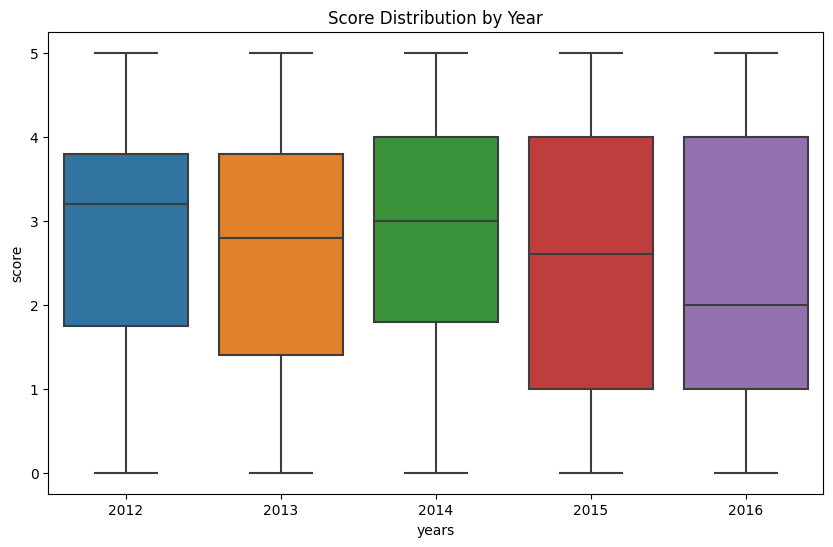

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='years', y='score', data=df_EDA, order=['2012', '2013', '2014', '2015', '2016'])
plt.title('Score Distribution by Year')
plt.show()


It is of interest to look at how the length of sentences affect the scores. We categorize the average length of a sentence into three categories: Short, medium and long sentences. Then we plot their score distributions

In [ ]:
# Define the boundaries for the categories
bins = [0, 10, 20, np.inf]
names = ['short', 'medium', 'long']

df_EDA['length_cat'] = pd.cut(df_EDA['avg_length'], bins, labels=names)

From the plot below, we can see that the longer sentences tend to have higher scores than the medium and short ones. In fact, no average sentence lengths of higher than 20 have a score of lower than 1

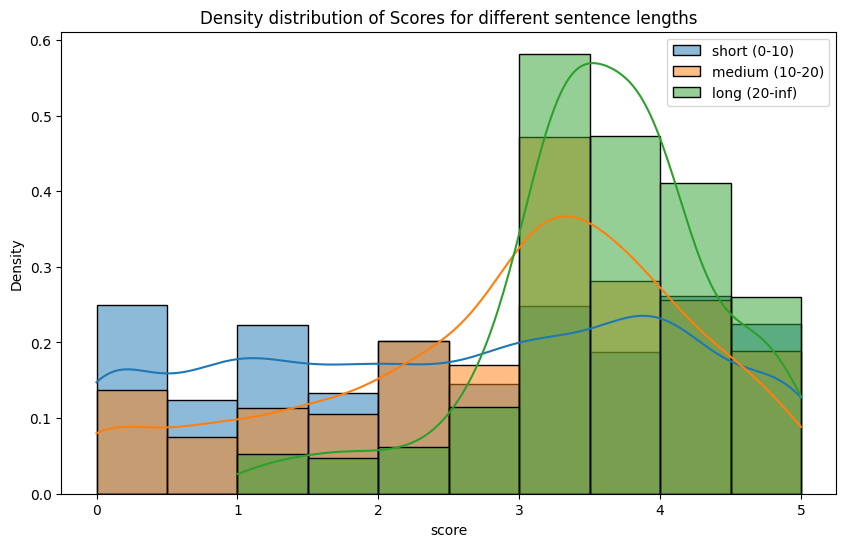

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_EDA.loc[df_EDA['length_cat'] == 'short', 'score'], label='short (0-10)', kde=True, bins=score_bins, stat='density')
sns.histplot(df_EDA.loc[df_EDA['length_cat'] == 'medium', 'score'], label='medium (10-20)', kde=True, bins=score_bins, stat='density')
sns.histplot(df_EDA.loc[df_EDA['length_cat'] == 'long', 'score'], label='long (20-inf)', kde=True, bins=score_bins, stat='density')
plt.title('Density distribution of Scores for different sentence lengths')
plt.legend()
plt.show()

## Clustering


### Word2Vec

Now let us look at some word embeddings and clustering using Word2Vec from Gensim. 

In [ ]:
train_sentences = list(flatten(train_df['sentence1'])) + list(flatten(train_df['sentence1'])) 
test_sentences = list(flatten(test_df['sentence1'])) + list(flatten(test_df['sentence1'])) 

train_sentences_token = [re.sub('\W', ' ', sentence).lower().split() for sentence in train_sentences]
test_sentences_token = [re.sub('\W', ' ', sentence).lower().split() for sentence in test_sentences]

In [ ]:
w2v_model = Word2Vec(train_sentences_token, vector_size=30, min_count=5, window=10)

In [ ]:
len(w2v_model.wv)

2955

The previous cell shows the vocab length of the W2V. A vocabulary of 2955 words is not a lot, but considering the length of the passages it's not that surprising. 

Checking what words the Word2Vec model finds most similar to the word 'plane': 

In [ ]:
w2v_model.wv.most_similar('plane')

[('dies', 0.9979137182235718),
 ('shooting', 0.997574508190155),
 ('include', 0.9972814917564392),
 ('between', 0.9968286156654358),
 ('rape', 0.9967337250709534),
 ('house', 0.9967323541641235),
 ('london', 0.9967234134674072),
 ('their', 0.9967067837715149),
 ('fraud', 0.9966479539871216),
 ('backs', 0.9966195225715637)]

In [ ]:
sample = random.sample(list(w2v_model.wv.key_to_index), 1000)

Getting the word vectors down to 3 dimentions such that we can plot them in a 3D plot. 

In [ ]:
word_vectors = w2v_model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

In [ ]:
x, y, z = np.transpose(tsne_embedding)

In [ ]:
# fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig = px.scatter_3d(x=x,y=y,z=z,text=sample)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In order to find out how large k should be while using kmeans, we used the elbow-method. 

In [ ]:
k_values = range(1, 11)  # Adjust the range as needed

# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Calculate WCSS for each K value
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(word_vectors)
    wcss.append(kmeans.inertia_)

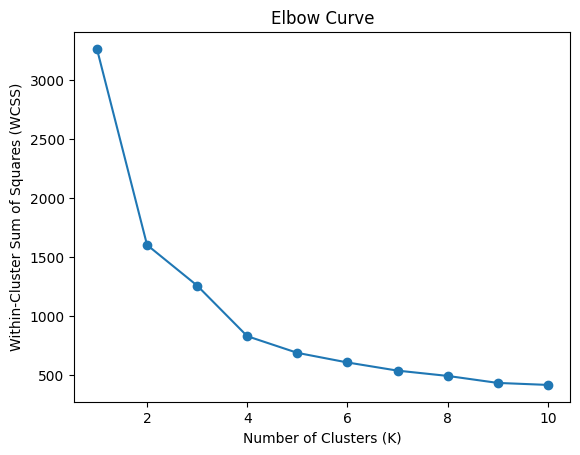

In [ ]:
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve')
plt.show()

From the plot we can see that 4 is a suitable number of clusters. Even though the largest elbow is at 2, there is a quite distinct elbow at 4 as well. 

In [ ]:
num_clusters = 4 
kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
kmeans.fit(word_vectors)

cluster_labels = kmeans.labels_

In [ ]:
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

[[  8.703989    -4.883939   -11.856592  ]
 [-13.115737    10.984024     1.1334752 ]
 [-19.671824     5.040267    -4.5657306 ]
 ...
 [ -7.5272384   -8.569614     3.2589447 ]
 [-12.456322     5.710221    -2.740534  ]
 [-14.570679    -6.6103373    0.91563606]]


<ipython-input-184-b3d193ea6e00>:10: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



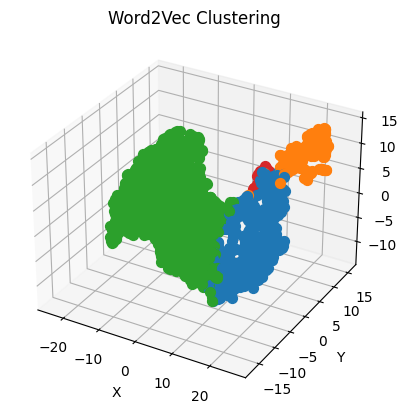

In [ ]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the clusters
color_map = plt.colormaps.get_cmap('tab10')

# Plot the points and color them based on cluster labels
for i, (x, y, z) in enumerate(tsne_embedding):
    ax.scatter(x, y, z, color=color_map(cluster_labels[i]), s=50)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Word2Vec Clustering')
plt.show()

In [ ]:
# Making interactive 3D plot using Plotly
scatter = go.Scatter3d(
    x=[vec[0] for vec in tsne_embedding],
    y=[vec[1] for vec in tsne_embedding],
    z=[vec[2] for vec in tsne_embedding],
    mode='markers',
    marker=dict(
        color=cluster_labels,
        size=5,
        colorscale='Viridis',
        opacity=0.8
    ), 
    text=sample
)

# Create the layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    title='Word2Vec Clustering'
)

# Create the figure and add the scatter plot
fig = go.Figure(data=[scatter], layout=layout)

# Display the figure
fig.show(renderer='colab')

### Hierarchical Clustering 

We were not satisfied with the results of the Word2Vec embedding and clustering. The nodes in the clusters seemed almost random, with some clusters having words that are related. Therefore, we decidede to try hierarchical clustering using SentenceTransformer and MiniLM as a model. As this can be quite computationally intensive, we have used the 500 first sentence pairs giving us 1000 sentences. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ST_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

In [ ]:
def miniLM_hierarchical_clustering(df):
    train_sentences1 = df['sentence1'].values
    train_sentences2 = df['sentence2'].values

    sentences = np.concatenate((train_sentences1, train_sentences2), axis=0)

    # Compute embedding for the concatenated list
    embedding = ST_model.encode(sentences)

    # Normalizing the embedding
    embedding = embedding /  np.linalg.norm(embedding, axis=1, keepdims=True)

    # Perform hierarchical clustering
    clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
    clustering_model.fit(embedding)
    cluster_assignment = clustering_model.labels_

    # Printing the content of all clusters
    clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []

        clustered_sentences[cluster_id].append(sentences[sentence_id])

    for i, cluster in clustered_sentences.items():
        print("Cluster ", i+1)
        print(cluster)
        print("")

    return embedding, clustering_model, sentences

Here the clustering is done using Agglomerate Clustering where the leaves are clustered iteratively clustered together based on similarity until all nodes are clustered into one root node. 

In [ ]:
embedding, clustering_model, sentences = miniLM_hierarchical_clustering(train_df[:500])

Cluster  88
['A plane is taking off.', 'An airplane is flying in the air.', 'An air plane is taking off.', 'A South African Airways plane is flying in a blue sky.']

Cluster  106
['A man is playing a large flute.', 'A man is playing a flute.', 'A man is playing a flute.', 'A man plays the flute.', 'A man is playing a flute in a band.', 'A man is playing a wooden flute while several other men play bongo drums.', 'A man is playing a flute.', 'A man is playing a bamboo flute.', 'A man is playing the flute.', 'A man is playing a flute.', 'A man is playing a flute.', 'A man is playing flute.', 'A man is playing a flute.', 'A man is playing a flute.']

Cluster  23
['A man is spreading shreded cheese on a pizza.', 'The man is eating pizza.', 'A man puts some cheese on a pizza.', 'A man is smelling two pizzas.', 'A man is spreading shredded cheese on an uncooked pizza.', 'A man is eating a slice of pizza.', 'The man sprinkled cheese on the pizza.']

Cluster  38
['Three men are playing chess.',

As we can see from the printed clusters, the sentence clustering is quite good. Most sentences in the same cluster have more or less the same thematic meaning.  

In [ ]:
def plot_dendrogram(model, **kwargs):

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create the linkage matrix
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

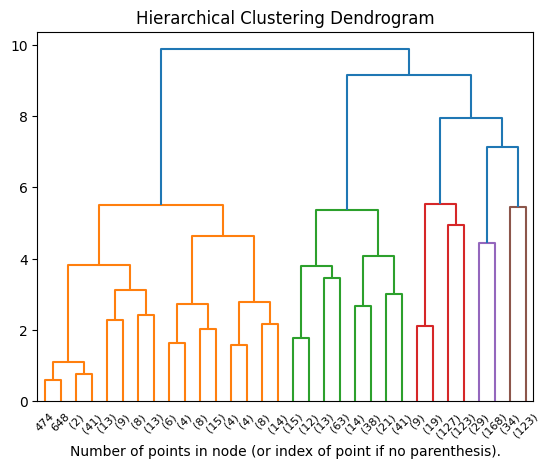

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top four levels of the dendrogram
plot_dendrogram(clustering_model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

From the dendrogram, we can see that there are many clusters, we have set the level cutoff at 4 levels, but that the clusters are in 5 main "clusters" of approximately equal size. 

In [ ]:
def get_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return dendrogram(linkage_matrix, no_plot=True)

In [ ]:
dendrogram = get_dendrogram(clustering_model)

Cluster 9: Two women are wrestling. (134, 0)
Cluster 9: Two women are wrestling on the floor. (634, 0)
Cluster 88: A woman is resting in a floating raft. (330, 0)
Cluster 88: People ride and paddle a raft. (339, 0)
Cluster 88: Four people are floating on a raft. (839, 0)
Cluster 8: Three teenage girls danced in the room. (257, 0)
Cluster 8: Some teenage girls are dancing for the camera. (757, 0)
Cluster 8: A group of people dance on a hill. (165, 0)
Cluster 8: A group of people are dancing. (665, 0)
Cluster 8: A boy is making some dance steps. (345, 0)
Cluster 8: Three boys are dancing. (241, 0)
Cluster 8: Kids are dancing. (741, 0)
Cluster 160: A woman is dancing and singing with other women. (32, 0)
Cluster 160: A woman is dancing with other women. (343, 0)
Cluster 160: Three women are dancing. (176, 0)
Cluster 160: The ladies are performing a dance. (927, 0)
Cluster 104: A woman is dancing by a fire. (238, 0)
Cluster 104: A woman is dancing in the street. (860, 0)
Cluster 104: A wom

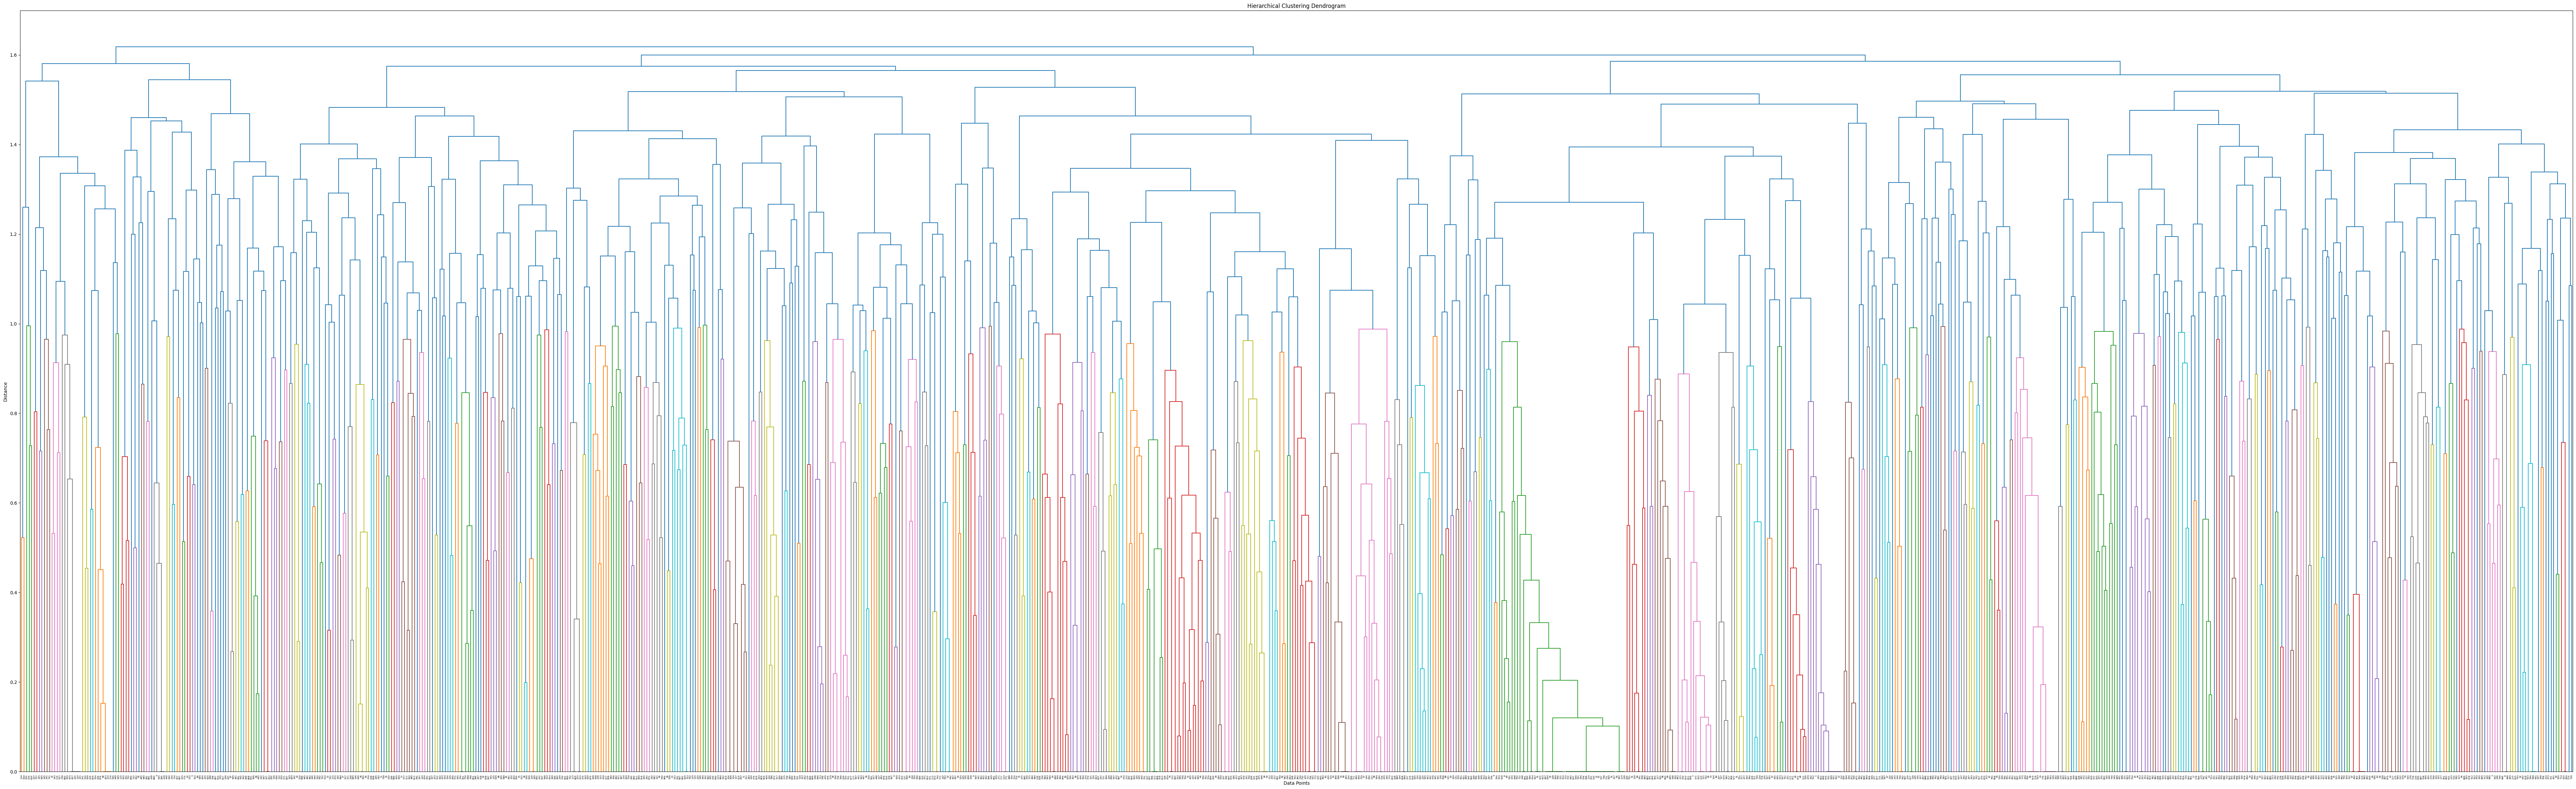

In [ ]:
# Compute the linkage matrix using hierarchical clustering
linkage_matrix = sch.linkage(embedding, method='complete')

# Plot the dendrogram
plt.figure(figsize=(100, 30))
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=1.0)  # Set the color threshold

# Add cluster labels to the leaves
leaf_indices = dendrogram['leaves']
leaf_labels = [sentences[idx] for idx in leaf_indices]
cluster_labels = clustering_model.labels_[leaf_indices]  # Assuming you have the cluster assignments

for idx, label, cluster in zip(leaf_indices, leaf_labels, cluster_labels):
    print(f"Cluster {cluster}: {label}", (idx, 0))

# Customize the plot
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')

# Display the plot
plt.show()

The last dendrogram is of all sentences and their connection to eachother. 

# Models

In [ ]:
random_numbers = np.random.uniform(0, 5, len(train_targets))
get_results(train_targets, random_numbers)

MSE: 4.329
RMSE: 2.081



(4.329477805060834, 2.080739725448821)

## TF-IDF similarity

This vectorization technique takes into account both the frequency of a word in a sentence (TF) and its rarity in the entire corpus (IDF). TF-IDF assigns higher weights to words that appear frequently in a sentence but are relatively rare in the corpus. This helps in capturing the importance of words in a sentence.

In [ ]:
vectorizer = TfidfVectorizer()

Let's have a quick look at the vocabulary. How big is it?

In [ ]:
# Fit and transform the vectorizer to the sentences
train_vectors = vectorizer.fit_transform(train_sentences)
train_vocab = vectorizer.get_feature_names_out()

valid_vectors = vectorizer.fit_transform(valid_sentences)
valid_vocab = vectorizer.get_feature_names_out()

test_vectors = vectorizer.fit_transform(test_sentences)
test_vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary train: {len(train_vocab)}\n")
print(f"Length of vocabulary valid: {len(valid_vocab)}\n")
print(f"Length of vocabulary test: {len(test_vocab)}\n")

Length of vocabulary train: 11397

Length of vocabulary valid: 6264

Length of vocabulary test: 4665



The decimial values are the TF-IDF scores for the terms. We can sort the terms of the first document by its TF-IDF values, and print them out as follows:

In [ ]:
print(sorted([(test_vocab[j], test_vectors[0, j]) for j in test_vectors[0].nonzero()[1]], key=lambda x: -x[1]))
print(test_sentences[0])

[('styling', 0.6103826121151986), ('hair', 0.524675445549931), ('her', 0.42331315032995503), ('girl', 0.3766734796006562), ('is', 0.1762719778855151)]
A girl is styling her hair.


In [ ]:
test_vectors[0].multiply(test_vectors[len(test_sentence1)]).sum() * 5

3.076812101724964

The dot-product between vectors computes the cosine of the angle between them. 
- The cosine of the angle between tf-idf vectors provides a value in the range [0,1], that is often used to measure the similarity between documents.
- Let's compute the similarity between the sentence1 and sentence2 and scale the result by  5 to get the appropriate proportion to the similiarity score.

In [ ]:
train_tf_idf_similarity = []
for i in range(len(train_sentence1)):
    train_tf_idf_similarity.append(train_vectors[i].multiply(train_vectors[i+len(train_sentence1)]).sum()*5)

valid_tf_idf_similarity = []
for i in range(len(valid_sentence1)):
    valid_tf_idf_similarity.append(valid_vectors[i].multiply(valid_vectors[i+len(valid_sentence1)]).sum()*5)

test_tf_idf_similarity = []
for i in range(len(test_sentence1)):
    test_tf_idf_similarity.append(test_vectors[i].multiply(test_vectors[i+len(test_sentence1)]).sum()*5)

train_results['tf-idf_score'] = train_tf_idf_similarity
valid_results['tf-idf_score'] = valid_tf_idf_similarity
test_results['tf-idf_score'] = test_tf_idf_similarity

print('Valid TF-IDf score:')
get_results(valid_targets, valid_tf_idf_similarity)
print('Test TF-IDf score:')
get_results(test_targets, test_tf_idf_similarity)

test_results.head(5)

Valid TF-IDf score:
MSE: 1.285
RMSE: 1.134

Test TF-IDf score:
MSE: 1.227
RMSE: 1.108



,genre,file,years,id,score,sentence1,sentence2,tf-idf_score
0,main-captions,MSRvid,2012test,24,2.5,A girl is styling her hair.,A girl is brushing her hair.,3.076812
1,main-captions,MSRvid,2012test,33,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.230313
2,main-captions,MSRvid,2012test,45,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,3.244828
3,main-captions,MSRvid,2012test,63,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.,3.308469
4,main-captions,MSRvid,2012test,66,1.5,A man is playing a harp.,A man is playing a keyboard.,1.875948


### Extending to include n-grams

In [ ]:
def get_tfidf_bow_n_gram_similarity(sent_list1, sent_list2, n):
  vectorizer = TfidfVectorizer(ngram_range=(1, n))

  sentences = sent_list1 + sent_list2
  vectors = vectorizer.fit_transform(sentences)

  tf_idf_similarity = []
  for i in range(len(sent_list1)):
      tf_idf_similarity.append(vectors[i].multiply(vectors[i+len(sent_list1)]).sum()*5)
  
  return tf_idf_similarity

similarity = get_tfidf_bow_n_gram_similarity(df_test['sentence1'].tolist(), df_test['sentence2'].tolist(), 3)


In [ ]:
tfidf_bow_n_gram_results = df_test.copy()

We would like to compare the mse-scores for the tf-idf n-grams. First, we compute the similarity score for each n-gram, and then we plot the mse values.

In [ ]:
n_range = [n for n in range(1,16)]
for n in n_range:
    tfidf_bow_n_gram_results[f'bow_{n}_gram_score'] = get_tfidf_bow_n_gram_similarity(df_test['sentence1'].tolist(), df_test['sentence2'].tolist(), n)

In [ ]:
tfidf_bow_n_gram_results.head(5)

,sentence1,sentence2,score,bow_1_gram_score,...,bow_12_gram_score,bow_13_gram_score,bow_14_gram_score,bow_15_gram_score
0,A girl is styling her hair.,A girl is brushing her hair.,2.5,3.076812,...,1.207776,1.207776,1.207776,1.207776
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6,3.230313,...,1.042746,1.042746,1.042746,1.042746
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0,3.244828,...,1.399401,1.399401,1.399401,1.399401
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2,3.308469,...,0.875786,0.875786,0.875786,0.875786
4,A man is playing a harp.,A man is playing a keyboard.,1.5,1.875948,...,1.406251,1.406251,1.406251,1.406251


In [ ]:
def extract_n_grams_mse_results(bow_n_gram_results):
  y_true = bow_n_gram_results['score'].values
  mse_results = []
  for method in bow_n_gram_results.iloc[:, 3:]:
      y_pred = bow_n_gram_results[method].values

      mse = mean_squared_error(y_true, y_pred)
      mse_results.append(mse)
  return mse_results

In [ ]:
tfidf_mse_results = extract_n_grams_mse_results(tfidf_bow_n_gram_results)

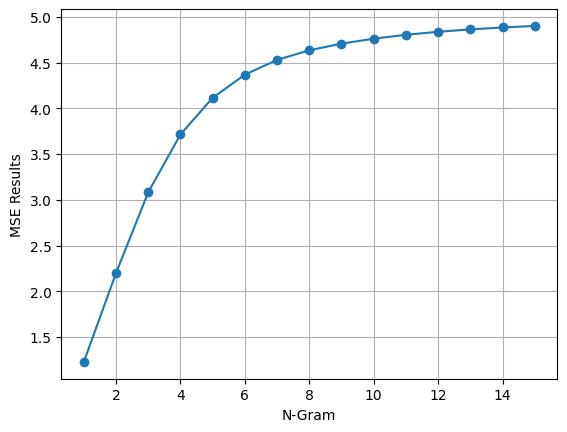

In [ ]:
plt.plot(n_range, tfidf_mse_results, marker='o', linestyle='-')
plt.xlabel("N-Gram")
plt.ylabel("MSE Results")
plt.grid(True)
plt.show()

Based on the graph, it can be concluded that the 1-gram have the lowest MSE.

# Average word embeddings

In [ ]:
# Load pre-trained Word2Vec model
fasttext_wiki = api.load("fasttext-wiki-news-subwords-300")
embeddings = [(fasttext_wiki, 'fasttext-wiki-news-subwords-300')]

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def avg_embedding_sentence_similarity(sentences1, sentences2, model):
    similarities = []
    for sent1, sent2 in zip(sentences1, sentences2):
        # Tokenize the sentences
        sent1_tokens = nltk.word_tokenize(sent1.lower())
        sent2_tokens = nltk.word_tokenize(sent2.lower())
        
        # Compute the average embedding for each sentence
        sent1_embedding = np.mean([model.get_vector(word) for word in sent1_tokens if word in model.key_to_index], axis=0)
        sent2_embedding = np.mean([model.get_vector(word) for word in sent2_tokens if word in model.key_to_index], axis=0)
        
        # Compute the cosine similarity between the two embeddings
        similarity = cosine_similarity([sent1_embedding], [sent2_embedding])[0][0]*5
        similarities.append(similarity)
    return similarities
similarity_train = avg_embedding_sentence_similarity(train_sentence1, train_sentence2, fasttext_wiki)
similarity_test = avg_embedding_sentence_similarity(test_sentence1, test_sentence2, fasttext_wiki)
similarity_valid = avg_embedding_sentence_similarity(val_sentence1, val_sentence2, fasttext_wiki)
# Reshape your data since sklearn requires input to be 2D array
similarity_train = np.array(similarity_train).reshape(-1, 1)
similarity_test = np.array(similarity_test).reshape(-1, 1)
similarity_valid = np.array(similarity_valid).reshape(-1, 1)



In [ ]:
avg_embedding_reg = find_polynomial_and_write_results(5, similarity_train, similarity_valid, similarity_test, 'avg_embedding_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.8913401037822888
Degree: 2, Validation MSE: 1.8471299159566386
Degree: 3, Validation MSE: 1.8304092035362707
Degree: 4, Validation MSE: 1.8264787876161548
Best degree: 4, Validation MSE: 1.8264787876161548
Best mse:  1.8970174814619174


# Doc2Vec


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# Tokenize all sentences and create a TaggedDocument for each sentence
all_sentences = train_sentences + val_sentences + test_sentences
tokenized_sentences = [nltk.word_tokenize(sentence.lower()) for sentence in all_sentences]
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sentences)]

# Train a Doc2Vec model on all sentences
model = Doc2Vec(tagged_data)


In [ ]:

def doc2vec(sentences1, sentences2, model):
    doc2vec_similarity = []
    for sentence1, sentence2 in zip(sentences1, sentences2):
        vector_1 = model.infer_vector(nltk.word_tokenize(sentence1.lower()))
        vector_2 = model.infer_vector(nltk.word_tokenize(sentence2.lower()))
        doc2vec_similarity.append(np.diagonal(cosine_similarity(vector_1.reshape(1, -1), vector_2.reshape(1, -1))))
    return doc2vec_similarity


similarity_train = doc2vec(train_sentence1, train_sentence2, model)
similarity_test = doc2vec(test_sentence1, test_sentence2, model)
similarity_valid = doc2vec(val_sentence1, val_sentence2, model)
# Reshape your data since sklearn requires input to be 2D array
similarity_train = np.array(similarity_train).reshape(-1, 1)
similarity_test = np.array(similarity_test).reshape(-1, 1)
similarity_valid = np.array(similarity_valid).reshape(-1, 1)



In [ ]:
doc2vec_reg = find_polynomial_and_write_results(5, similarity_train, similarity_valid, similarity_test, 'doc2vec_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.808153717410048
Degree: 2, Validation MSE: 1.8074229967039048
Degree: 3, Validation MSE: 1.8074181937179905
Degree: 4, Validation MSE: 1.808803807188638
Best degree: 3, Validation MSE: 1.8074181937179905
Best mse:  1.6925325711599362


## Word Mover's Distance (WMD) 

is a method used to measure the semantic similarity between two sentences. It takes into account the distance between word embeddings in a vector space.

In [ ]:
word_vectors = fasttext_wiki

def wmd(sentences1, sentences2):
  wmd_similarity = []
  for sentence1, sentence2 in zip(sentences1, sentences2):
    sent1_tokens = nltk.word_tokenize(sentence1.lower())
    sent2_tokens = nltk.word_tokenize(sentence2.lower())
    instance = WmdSimilarity([sent1_tokens], word_vectors)
    similarity = instance.get_similarities([sent2_tokens])[0]
    wmd_similarity.append(similarity)
  return wmd_similarity

# Assuming you have a variable `train_scores` and `test_scores` which is your target scores for train and test data.
similarity_train = wmd(train_sentence1, train_sentence2)
similarity_test = wmd(test_sentence1, test_sentence2)
similarity_valid = wmd(val_sentence1, val_sentence2)
# Reshape your data since sklearn requires input to be 2D array
similarity_train = np.array(similarity_train).reshape(-1, 1)
similarity_test = np.array(similarity_test).reshape(-1, 1)
similarity_valid = np.array(similarity_valid).reshape(-1, 1)



In [ ]:
wmd_reg = find_polynomial_and_write_results(20, similarity_train, similarity_valid, similarity_test, 'wmd_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.6127695309015813
Degree: 2, Validation MSE: 1.5677195479390484
Degree: 3, Validation MSE: 1.5674148261398115
Degree: 4, Validation MSE: 1.5627821624318043
Degree: 5, Validation MSE: 1.5546728125457805
Degree: 6, Validation MSE: 1.5543950125671724
Degree: 7, Validation MSE: 1.554674937069531
Degree: 8, Validation MSE: 1.5520057099096267
Degree: 9, Validation MSE: 1.552300518624007
Degree: 10, Validation MSE: 1.5523822672258232
Degree: 11, Validation MSE: 1.5521992039765304
Degree: 12, Validation MSE: 1.5520332257954634
Degree: 13, Validation MSE: 1.553443431792741
Degree: 14, Validation MSE: 1.5541939835928207
Degree: 15, Validation MSE: 1.5540774613781825
Degree: 16, Validation MSE: 1.5538563588835987
Degree: 17, Validation MSE: 1.5532579658080785
Degree: 18, Validation MSE: 1.5531344252475394
Degree: 19, Validation MSE: 1.5534047488795606
Best degree: 8, Validation MSE: 1.5520057099096267
Best mse:  1.4528787844675686


## Universal Sentence Encoder


The Universal Sentence Encoder (USE) is a natural language processing (NLP) model developed by Google that converts sentences or short texts into fixed-length vector representations, also known as embeddings. These embeddings capture the semantic meaning of the sentences and enable various downstream tasks, such as text classification, clustering, semantic similarity calculation, and more. The USE model is based on deep learning techniques, specifically using a variation of the Transformer architecture. 

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

logging.set_verbosity(logging.ERROR)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def use(sentence1, sentence2):
  similarity = []
  embeddings1 = model(sentence1)
  embeddings2 = model(sentence2)
  similarity = np.diagonal(cosine_similarity(embeddings1, embeddings2)).reshape(-1,1)
  return similarity

similarity_train = use(train_sentence1, train_sentence2)
similarity_valid = use(val_sentence1, val_sentence2)
similarity_test = use(test_sentence1, test_sentence2)

In [ ]:
use_reg = find_polynomial_and_write_results(20, similarity_train, similarity_valid, similarity_test, 'use_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 0.8521547371490016
Degree: 2, Validation MSE: 0.824094421736926
Degree: 3, Validation MSE: 0.8089749759671413
Degree: 4, Validation MSE: 0.8183867277296574
Degree: 5, Validation MSE: 0.8101683893292277
Degree: 6, Validation MSE: 0.8110170305264955
Degree: 7, Validation MSE: 0.8088983539574571
Degree: 8, Validation MSE: 0.8089095871819914
Degree: 9, Validation MSE: 0.8087173723332519
Degree: 10, Validation MSE: 0.8078601346471234
Degree: 11, Validation MSE: 0.823638256093447
Degree: 12, Validation MSE: 0.8106858055993736
Degree: 13, Validation MSE: 0.8082064245607007
Degree: 14, Validation MSE: 0.9433617383598369
Degree: 15, Validation MSE: 0.8984807459347418
Degree: 16, Validation MSE: 0.9007234217460024
Degree: 17, Validation MSE: 0.8644036474062141
Degree: 18, Validation MSE: 0.837803968506954
Degree: 19, Validation MSE: 0.8254993862597356
Best degree: 10, Validation MSE: 0.8078601346471234
Best mse:  0.8078601346471234


## InferSent

InferSent is a sentence embeddings method that utilizes a bi-directional LSTM (Long Short-Term Memory) network to encode sentences into fixed-length vectors. It is trained on various natural language understanding tasks, enabling it to capture sentence semantics and infer similarity.

https://github.com/facebookresearch/InferSent?fbclid=IwAR0j7JJDc4HiTtg1fKMVjDMYDFw7EqALWWygDsAGiRVeSGQ6oednJfUozHc

In [ ]:
# !git clone https://github.com/facebookresearch/InferSent.git
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip
%cd InferSent
from models import InferSent
%cd ..

/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project


In [ ]:
model_version = 1
MODEL_PATH = 'encoder/infersent%s.pkl' % model_version
W2V_PATH = 'glove.840B.300d.txt'
VOCAB_SIZE = 1e4  # Load embeddings of VOCAB_SIZE most frequent words
USE_CUDA = False  # Keep it on CPU if False, otherwise will put it on GPU

In [ ]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [ ]:
model = model.to(device)
model.set_w2v_path(W2V_PATH)
# model.build_vocab_k_words(K=VOCAB_SIZE)
model.build_vocab(train_sentences + val_sentences + test_sentences, tokenize=True)

Found 17559(/18457) words with w2v vectors
Vocab size : 17559


In [ ]:
def infersent(sentences1, sentences2):
  embeddings1 = model.encode(sentences1, tokenize=True, verbose=False) # bsize=128
  embeddings2 = model.encode(sentences2, tokenize=True, verbose=False) # bsize=128

  infersent_sim = np.diagonal(cosine_similarity(embeddings1, embeddings2)).reshape()
  return infersent_sim
similarity_train = infersent(train_sentence1, train_sentence2)
similarity_valid = infersent(val_sentence1, val_sentence2)
similarity_test = infersent(test_sentence1, test_sentence2)

/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray fro

In [ ]:
similarity_train = similarity_train.reshape(-1,1)
similarity_valid = similarity_valid.reshape(-1,1)
similarity_test = similarity_test.reshape(-1,1)

In [ ]:
use_reg = find_polynomial_and_write_results(20, similarity_train, similarity_valid, similarity_test, 'infersent_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.024905302419149
Degree: 2, Validation MSE: 1.0023382510699446
Degree: 3, Validation MSE: 0.9857872404845666
Degree: 4, Validation MSE: 0.9888753523062266
Degree: 5, Validation MSE: 0.9880631820872415
Degree: 6, Validation MSE: 0.9880945332233677
Degree: 7, Validation MSE: 0.9956078390465855
Degree: 8, Validation MSE: 0.9930782339790873
Degree: 9, Validation MSE: 0.990413137700537
Degree: 10, Validation MSE: 0.9906282869411172
Degree: 11, Validation MSE: 0.9908896945551448
Degree: 12, Validation MSE: 0.9909988579017217
Degree: 13, Validation MSE: 0.9905868588749802
Degree: 14, Validation MSE: 0.9926051239606783
Degree: 15, Validation MSE: 0.9920922905386236
Degree: 16, Validation MSE: 0.9913755434175162
Degree: 17, Validation MSE: 0.9912749089837963
Degree: 18, Validation MSE: 0.9912067003474836
Degree: 19, Validation MSE: 0.9919904122162538
Best degree: 3, Validation MSE: 0.9857872404845666
Best mse:  0.9857872404845666


## BERT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [ ]:
# For sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = list(map(tuple, df_train[['sentence1', 'sentence2']].values))
x_val = list(map(tuple, df_valid[['sentence1', 'sentence2']].values))
x_test = list(map(tuple, df_test[['sentence1', 'sentence2']].values))

y_train = df_train['score'].values
y_val = df_train['score'].values
y_test = df_test['score'].values

In [ ]:
# Load a pre-trained transformer model
model_name = 'bert-base-cased'
transformer = text.Transformer(model_name, maxlen=512)

Run the learner to do some simulated runs and try to determine the best setting of the learning rate.

In [ ]:
processed_train = transformer.preprocess_train(x_train, y_train)
processed_val = transformer.preprocess_test(x_val, y_val)
processed_test = transformer.preprocess_test(x_test, y_test)

model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)
# learner.lr_find(show_plot=True, max_epochs=1)

preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


preprocessing test...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


Based on the plot above, we'll select a learning rate of 5*10^-5. The recommendation from ktrain is to choose as big a value as possible where the loss is still decreasing 

lr 5*10^-3 Test MSE: 2.328

lr 5*10^-4 Test MSE: 2.379

lr 3*10^-4 Test MSE: 0.583

lr 5*10^-5 Test MSE: 0.575

lr 7*10^-5 Test MSE: 0.577

lr 1*10^-5 Test MSE: 0.689




lr 5*10^-5:

1 epoch, 6 batch: Train MSE: 0.595, Val MSE: 0.779

2 epoch, 6 batch: Train MSE: 0.223, Val MSE: 0.578

3 epoch, 6 batch: Train MSE: 0.154, Val MSE: 0.575

10 epoch using autofit, Train MSE: 0.081, Test MSE: 0.59



In [ ]:
learner.fit_onecycle(5e-5, 2)
#learner.autofit(5e-5)

predictor = ktrain.get_predictor(learner.model, transformer)#.save('/BERT/2-epochs_5e-5')
predictor.save('/BERT/2-epochs_5e-5')
# model = ktrain.load_predictor('/BERT/2-epochs_5e-5').model
# learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/2
719/719 [==============================] - 681s 920ms/step - loss: 1.2961 - mae: 0.8935 - val_loss: 3.9924 - val_mae: 1.6348
Epoch 2/2
719/719 [==============================] - 661s 919ms/step - loss: 0.5206 - mae: 0.5556 - val_loss: 4.0521 - val_mae: 1.6308


In [ ]:
train_bert_similarity = predictor.predict(x_train)
val_bert_similarity = predictor.predict(x_val)
test_bert_similarity = predictor.predict(x_test)

print("Train:")
train_results['bert_score'] = train_bert_similarity
get_results(train_targets, train_bert_similarity)

print("Val:")
valid_results['bert_score'] = val_bert_similarity
get_results(valid_targets, val_bert_similarity)

print("Test:")
test_results['bert_score'] = test_bert_similarity
get_results(test_targets, test_bert_similarity)

free_gpu_cache()

Train:
MSE: 0.219
RMSE: 0.468

Val:
MSE: 0.565
RMSE: 0.752

Test:
MSE: 0.726
RMSE: 0.852

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 90% | 93% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 93% |


## RoBERTa

In [ ]:
model_name = 'roberta-base'
transformer = text.Transformer(model_name, maxlen=512)
processed_train = transformer.preprocess_train(x_train, y_train)
processed_val = transformer.preprocess_test(x_val, y_val)
processed_test = transformer.preprocess_test(x_test, y_test)

model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_val, batch_size=8)

preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


preprocessing test...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


roberta-base:


1 epoch Train MSE: 0.383 Test MSE: 0.548

2 epochs: Train MSE: 0.25 Test MSE: 0.485

3 epochs: Train MSE: 0.229 Test MSE: 0.495




In [ ]:
learner.fit_onecycle(5e-5, 2)
# learner.autofit(5e-5)
predictor = ktrain.get_predictor(learner.model, transformer)
predictor.save('2-epochs_5e-5')



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/2
719/719 [==============================] - 691s 930ms/step - loss: 1.1232 - mae: 0.8067 - val_loss: 5.0600 - val_mae: 1.8231
Epoch 2/2
719/719 [==============================] - 665s 925ms/step - loss: 0.5235 - mae: 0.5608 - val_loss: 4.3588 - val_mae: 1.6861


AttributeError: ignored

In [ ]:
train_roberta_similarity = predictor.predict(x_train)
val_roberta_similarity = predictor.predict(x_val)
test_roberta_similarity = predictor.predict(x_test)

print("Train:")
train_results['roberta_score'] = train_roberta_similarity
get_results(train_targets, train_roberta_similarity)

print("Val:")
valid_results['roberta_score'] = val_roberta_similarity
get_results(valid_targets, val_roberta_similarity)

print("Test:")
test_results['roberta_score'] = test_roberta_similarity
get_results(test_targets, test_roberta_similarity)

free_gpu_cache()

Train:
MSE: 0.249
RMSE: 0.499

Val:
MSE: 0.463
RMSE: 0.68

Test:
MSE: 0.571
RMSE: 0.756

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 57% | 93% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 93% |


## GPT2

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=1)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

class SentenceSimilarityDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]


def preprocess_data(sentence_pairs, similarity_scores):
    tokenizer.pad_token = tokenizer.eos_token
    tokenized_pairs = tokenizer.batch_encode_plus(
        sentence_pairs,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized_pairs["input_ids"]
    attention_mask = tokenized_pairs["attention_mask"]
    labels = torch.tensor(similarity_scores)
    return input_ids, attention_mask, labels


In [ ]:
def fine_tune_model(trian_input_ids, train_attention_mask, train_labels):
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = model.config.eos_token_id
    optimizer = AdamW(model.parameters(), lr=1e-5)

    train_dataset = SentenceSimilarityDataset(trian_input_ids, train_attention_mask, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)

    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 2
    for epoch in range(num_epochs):
        tqdm_train = tqdm(train_dataloader, total=len(train_dataloader))

        total_loss = 0
        train_similarities = []
        model.train()
        for batch in tqdm_train:
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        print(f"Epoch: {epoch + 1}, Average Loss: {average_loss}")

    return model

In [ ]:
x_train = list(map(tuple, df_train[['sentence1', 'sentence2']].values))
x_val = list(map(tuple, df_valid[['sentence1', 'sentence2']].values))
x_test = list(map(tuple, df_test[['sentence1', 'sentence2']].values))

y_train = torch.tensor(df_train['score'].values, dtype=torch.float32)
y_val = torch.tensor(df_valid['score'].values, dtype=torch.float32)
y_test = torch.tensor(df_test['score'].values, dtype=torch.float32)

train_input_ids, train_attention_mask, train_labels = preprocess_data(x_train, y_train)
val_input_ids, val_attention_mask, val_labels = preprocess_data(x_val, y_val)
test_input_ids, test_attention_mask, test_labels = preprocess_data(x_test, y_test)

model = fine_tune_model(train_input_ids, train_attention_mask, train_labels)

<ipython-input-21-836abe0a6a1d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(similarity_scores)


  0%|          | 0/1917 [00:00<?, ?it/s]

Epoch: 1, Average Loss: 3.075121876956136
MSE: 4.229
RMSE: 2.057



  0%|          | 0/1917 [00:00<?, ?it/s]

Epoch: 2, Average Loss: 1.0481363478496604
MSE: 3.43
RMSE: 1.852



1 Epoch:

Train:
MSE: 0.647
RMSE: 0.805

Vaild:
MSE: 0.86
RMSE: 0.927

Test:
MSE: 0.947
RMSE: 0.973

2 Epochs:

Train:
MSE: 0.583
RMSE: 0.763

Valid:
MSE: 0.724
RMSE: 0.851

Test:
MSE: 0.863
RMSE: 0.929

In [ ]:
def predict_similarity(model, sentence_pair, similarity_score):
    input_ids, attention_mask, labels = preprocess_data([sentence_pair], similarity_score)
    model.to('cpu')

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    similarity_score = outputs.logits.item()
    return similarity_score

def gpt2(model, x, y):
  gpt2_score = []
  cap = 0.1
  for i, sentence_pair in enumerate(x):
    gpt2_score.append(predict_similarity(model, sentence_pair, y))
    if (i + 1) / len(x) > cap:
      print(f'{round(cap*100)}%')
      cap += 0.1
  return gpt2_score

print('Train:')
train_gpt2_score =  gpt2(model, x_train, y_train)
get_results(y_train, train_gpt2_score)
train_results['gpt2_score'] = train_gpt2_score

print('Valid:')
val_gpt2_score =  gpt2(model, x_val, y_val)
get_results(y_val, val_gpt2_score)
valid_results['gpt2_score'] = val_gpt2_score

print('Test:')
test_gpt2_score =  gpt2(model, x_test, y_test)
get_results(test_labels, test_gpt2_score)
test_results['gpt2_score'] = test_gpt2_score

<ipython-input-21-836abe0a6a1d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(similarity_scores)


10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
99.99999999999999%
MSE: 0.583
RMSE: 0.763



<ipython-input-21-836abe0a6a1d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(similarity_scores)


10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
99.99999999999999%
MSE: 0.724
RMSE: 0.851



<ipython-input-21-836abe0a6a1d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(similarity_scores)


10.0%
20.0%
30.000000000000004%
40.0%
50.0%
60.0%
70.0%
80.0%
89.99999999999999%
99.99999999999999%
MSE: 0.863
RMSE: 0.929



In [ ]:
free_gpu_cache()

## Sentence-BERT

Sentence Embeddings using Siamese BERT-Networks

### all-MiniLM-L6-v2 

The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models. The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. 
(https://huggingface.co/tasks/sentence-similarity)

In [ ]:
device = torch.device('cuda')

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

def miniLM(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  #Compute embedding for both lists
  embedding_1 = model.encode(train_sentences1, convert_to_tensor=True) 
  embedding_2 = model.encode(train_sentences2, convert_to_tensor=True)

  MiniLM_similarity = torch.diagonal(util.pytorch_cos_sim((embedding_1), (embedding_2))).cpu()
  MiniLM_similarity[MiniLM_similarity < 0] = 0 # Sentences that are opposing should just be zero
  MiniLM_similarity = MiniLM_similarity * 5
  results['miniLM_score'] = MiniLM_similarity
  get_results(targets, MiniLM_similarity)

print('Valid:')
miniLM(df_valid, valid_results, valid_targets)
print('Test:')
miniLM(df_test, test_results, test_targets)

Valid:
MSE: 0.788
RMSE: 0.887

Test:
MSE: 0.918
RMSE: 0.958



### all-mpnet-base-v2

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def mpnet(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  # Compute embedding for both lists
  embedding_1 = model.encode(train_sentences1, convert_to_tensor=True) 
  embedding_2 = model.encode(train_sentences2, convert_to_tensor=True)

  mpnet_similarity = torch.diagonal(util.pytorch_cos_sim(embedding_1, embedding_2)).cpu()
  mpnet_similarity[mpnet_similarity < 0] = 0 # Sentences that are opposing should just be zero
  mpnet_similarity = mpnet_similarity * 5
  results['mpnet_score'] = mpnet_similarity
  get_results(targets, mpnet_similarity)

print('Valid:')
mpnet(df_valid, valid_results, valid_targets)
print('Test:')
mpnet(df_test, test_results, test_targets)

Valid:
MSE: 0.726
RMSE: 0.852

Test:
MSE: 0.812
RMSE: 0.901



## Stacking

A problem with using this ensemble method is that the feature importance might be biased on BERT because the score from the training is overfitted. We tested this issue and noticed that romving the BERT score improved the final score significantly.

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = ['tf-idf_score', 'bm25_score', 'bow_score' , 'avg_embeddings_score', 'doc2vec_score', 'wmd_score',
            'use_score', 'infersent_score', 'bert_score', 'roberta_score', 'gpt2_score',
            'miniLM_score', 'mpnet_score']

x_val = valid_results[features].values
y_val = df_valid['score'].values

x_test = test_results[features].values
y_test = df_test['score'].values

# Convert your data to LightGBM dataset format
train_data = lgb.Dataset(x_val, label=y_val, feature_name=features)

# Set up the parameters for LightGBM training
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 17,
    'learning_rate': 0.03,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 4,
    'force_col_wise':True,
    'verbose': 0
}

num_round = 250

print('LightGBM:')
model = lgb.train(params, train_data, num_boost_round=num_round)
y_pred = model.predict(x_test)
get_results(y_pred, test_targets)
plot = lgb.plot_importance(model)
plt.show()

print('XGBoost')
train_data = xgb.DMatrix(x_val, label=y_val, feature_names=features)
x_test = xgb.DMatrix(x_test, feature_names=features)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.07,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
}

model = xgb.train(params, train_data, num_round)
y_pred = model.predict(x_test)
get_results(y_pred, test_targets)
xgb.plot_importance(model, importance_type='gain', title='Feature importance', show_values=False)
plt.show()


KeyError: ignored